In [250]:
# So ... each agent also has a type ideally

#Thought: with the type, we could set it within the agent itself.
#That way only need to pass the type?
#
#I guess that agents don't have access to the model?

In [251]:
# https://stackoverflow.com/questions/19620498/how-to-create-a-utility-class-correctly

# Okay... so... 
We have agents...

Suspicious ones
Not suspicious ones


Transactions should have:


We also want to export the network of transactions

So... the data we want are... 

sender - receiver - amount - timestamp

parameters:

num of agents,
avg txn hr -> so at any given point, the likelihood of making a transaction

avg txn value
distribution of p per agent type 
starting balance




In [252]:
# export some... network graphs i guess....
# also want to make some classifieirs

In [320]:
# Model design
import agentpy as ap
import numpy as np

# Visualization
import seaborn as sns
import pandas as pd

import scipy.stats
import datetime
import matplotlib.pyplot as plt

from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

In [254]:
# work
rng = np.random.default_rng(42)
rng.random()
rng.normal(loc=0, scale=1, size=1)

array([-1.03998411])

# utility functions

In [255]:
DEBUG = False

def setup_p_txns(total_steps):
    # Mean at 0
    max_std_devs = 5 # 

    if DEBUG:
        # Note: scipy norm has stddev = 1, mean of 0
        # Below shows why we pick max_std_devs = 5
        p_txn = scipy.integrate.quad(
                scipy.stats.norm.pdf, -5, 5)[0] # quad() Returns: value, error
        print('In total we will capture this amount of the gaussian: ', p_txn)
    
    txn_probabilities = []

    std_dev_per_step = 2 * max_std_devs / total_steps

    for step in range(total_steps):
        p_txn = \
            scipy.integrate.quad(
                scipy.stats.norm.pdf, 
                step * std_dev_per_step, (step+1) * std_dev_per_step
            ) # returns: (integration) value, error
        txn_probabilities.append(p_txn[0])
    if DEBUG:
        txn_probabilities[0] = 1 # set p_txn to 1 to always transact
        txn_probabilities[-1] = 1
        txn_probabilities[1:-1] = 0
    return txn_probabilities

# agent

In [291]:
class BankAgent(ap.Agent):
    def setup(self):
        self.txn_amt_rng = None 
        self.txn_probabilities = None 
        self.type = None 
        self.acct_balance = None 
        self.mean_txns = 4
        self.send_txn_times = []

        self.txns = pd.DataFrame(
                columns=['timestep', 'txn_type', 'sender_id', 'sender_type', 
                 'receiver_id', 'receiver_type', 'amount', 'acct_balance',] 
        )
        self.txn_amts = None

    def setup_txn_amts(self, mean=100, stddev=10, total_steps=0):
        self.txn_amts = self.txn_amt_rng.normal(
            loc=mean, scale=stddev, 
            size=total_steps)

    def transact(self, timestep):
        p_txn = self.txn_probabilities[timestep-1] * self.mean_txns
        if np.random.random() < p_txn and self.acct_balance > 0:
            self.send_txn_times.append(timestep)
            # randomly choose partner
            my_partner = self.model.agents.random() # we get a list back
            my_partner = my_partner.to_list()[0] 
            # randomly choose amount
            amount = self.txn_amts[timestep]

            # calculations
            my_partner.acct_balance += amount
            self.acct_balance -= amount

            if DEBUG:
                print(
                    f' Transaction @ step: {timestep} with ptxn: {p_txn:.2f}, '
                    f'${amount:.2f} from: {self.id}->{my_partner.id}, '
                    f'({self.type} to {my_partner.type}), new balance: {self.acct_balance:.1f}'
                )

            # Note that txn_type is redundant info (e.g. can be derived from +/- of amount)
            self.txns.loc[len(self.txns.index)] = [
                timestep, 'send', self.id, self.type, my_partner.id, my_partner.type,
                -amount, self.acct_balance]

            my_partner.txns.loc[len(my_partner.txns.index)] = [
                timestep, 'receive', self.id, self.type, my_partner.id, my_partner.type,
                amount, my_partner.acct_balance]

# parameters

In [292]:
        #self.txn_value_rng = p.rng
        #self.txn_probabilities = p.txn_probabilities
        ##self.p.type = 'default'
        #self.type = self.p.type
        #self.acct_balance = self.p.init_acct_balance

MEAN_TXN_HRS = {'normal':14, 
                'suspicious':22}
MINS_PER_STEP = 15

MEAN_TXN_AMOUNTS = {'normal':250, 
                'suspicious':50}

NUM_AGENTS_PER_TYPE = {'normal': 10,
    'suspicious': 2
}

parameters = {
    'num_agents_per_type': NUM_AGENTS_PER_TYPE,
    'mean_txn_hrs': MEAN_TXN_HRS,
    'mean_txn_amounts ': MEAN_TXN_AMOUNTS,
    'mean_txns': 4, # avg num txns each agent makes
    'starting_balance': 100,
    'seed': 42,
    'mins_per_step' : MINS_PER_STEP, # 1 hr
    'steps': int(24 * (60/MINS_PER_STEP)), # 24 hours * steps per hr
}

# For plotting
def timestep_to_time(timestep):
    date_and_time = datetime.datetime(2022, 10, 31, 0, 0, 0)
    time_elapsed = timestep * (parameters['mins_per_step'])
    time_change = datetime.timedelta(minutes=time_elapsed)
    new_time = date_and_time + time_change
    return new_time

In [296]:
class BankModel(ap.Model):
    def setup(self):
        self.p_txns = setup_p_txns(self.p.steps) 
        num_agents = sum(self.p.num_agents_per_type.values())
        
        # Setup up rng to generate seeds for rngs for agents
        rng = np.random.default_rng(self.p.seed)
        agent_rng_seeds = rng.random(num_agents).round(3) * 1000
        agent_rng_seeds = np.array(agent_rng_seeds, dtype=int)

        self.agents = ap.AgentList(self) 
        for type in ['normal', 'suspicious']:

            hrs_mean = self.p.mean_txn_hrs[type]
            shift = hrs_mean * int(60 / self.p.mins_per_step)
            # shift in steps
            shifted = np.concatenate(
                (self.p_txns[-shift:], self.p_txns[:-shift]))
            agents = ap.AgentList(
                self, self.p.num_agents_per_type[type], BankAgent)

            agents.txn_probabilities = shifted
            agents.total_steps = self.p.steps 
            agents.acct_balance = 100
            agents.type = type

            self.agents += agents

        print('here are all the agetns: ')
        print(self.agents)
        print([(agent.id,agent.type) for agent in self.agents])

        # calcuations for txn values
        txn_amt_rngs = ap.AttrIter(
            [np.random.default_rng(seed) for seed in agent_rng_seeds])
        self.agents.txn_amt_rng = txn_amt_rngs

        for agent in self.agents:
            agent.setup_txn_amts(
                mean=20, stddev=5, total_steps=self.p.steps)
                #mean=20, stddev=5, total_steps=self.p.mean_txns * 5)
            # TODO: maybe I should make smaller table...? 
            # but then need to index into it, not by timestep
            # fundamental issue is ... wanting a same set of rngs for each agent
            # but cannot call at each timestep -- would get same value -- so instead pregenerate the values for all timesteps and then index into that
            #print(agent.txn_amts)
            #print(agent.id)
            #print(agent.type)

    def step(self):
        self.agents.transact(self.t)

    def update(self):
        total_txns = 0
        for agent in self.agents:
            num_txns = agent.txns[agent.txns.txn_type == 'send'].shape[0]
            total_txns += num_txns
        print('num txns (across all agents)', total_txns)

    def end(self):
        self.agents.record('send_txn_times')
        #self.agents.record('txns')

In [297]:
np.random.default_rng(42).normal()

0.30471707975443135

In [298]:
model = BankModel(parameters)
results = model.run()

here are all the agetns: 
AgentList (12 objects)
[(1, 'normal'), (2, 'normal'), (3, 'normal'), (4, 'normal'), (5, 'normal'), (6, 'normal'), (7, 'normal'), (8, 'normal'), (9, 'normal'), (10, 'normal'), (11, 'suspicious'), (12, 'suspicious')]
num txns (across all agents) 0
num txns (across all agents) 1
Completed: 1 stepsnum txns (across all agents) 2
Completed: 2 stepsnum txns (across all agents) 2
Completed: 3 stepsnum txns (across all agents) 2
Completed: 4 stepsnum txns (across all agents) 2
Completed: 5 stepsnum txns (across all agents) 2
Completed: 6 stepsnum txns (across all agents) 2
Completed: 7 stepsnum txns (across all agents) 2
Completed: 8 stepsnum txns (across all agents) 2
Completed: 9 stepsnum txns (across all agents) 2
Completed: 10 stepsnum txns (across all agents) 2
Completed: 11 stepsnum txns (across all agents) 2
Completed: 12 stepsnum txns (across all agents) 2
Completed: 13 stepsnum txns (across all agents) 2
Completed: 14 stepsnum txns (across all agents) 2
Comple

In [299]:
# For plotting
def timestep_to_time(timestep):
    date_and_time = datetime.datetime(2022, 10, 31, 0, 0, 0)
    time_elapsed = timestep * (parameters['mins_per_step'])
    time_change = datetime.timedelta(minutes=time_elapsed)
    new_time = date_and_time + time_change
    return new_time

In [300]:
for agent in model.agents:
    print(agent.txns)

   timestep txn_type  sender_id sender_type  receiver_id receiver_type  \
0        63  receive          2      normal            1        normal   
1        63  receive          8      normal            1        normal   
2        64     send          1      normal            2        normal   
3        65     send          1      normal            4        normal   
4        68     send          1      normal            9        normal   
5        70     send          1      normal            1        normal   
6        70  receive          1      normal            1        normal   

      amount  acct_balance  
0  14.829632    114.829632  
1  26.270740    141.100373  
2 -21.567786    119.532586  
3 -21.608799     97.923787  
4 -19.045538     78.878249  
5 -23.566835     78.878249  
6  23.566835     78.878249  
   timestep txn_type  sender_id sender_type  receiver_id receiver_type  \
0        60  receive          5      normal            2        normal   
1        62  receive       

In [301]:
# transaction amount, sender, receiver, timestamp

In [302]:
results.info

{'model_type': 'BankModel',
 'time_stamp': '2022-12-09 17:12:48',
 'agentpy_version': '0.1.5',
 'python_version': '3.10.',
 'experiment': False,
 'completed': True,
 'created_objects': 12,
 'completed_steps': 96,
 'run_time': '0:00:00.239107'}

In [303]:
# okay so now i want to... uh... okay histogram plot of when txns are occuring
# then i want to ... make a network of who transacted with who

In [304]:
model.agents.acct_balance

[78.87824869667821, 149.75781767277408, 102.0368978970519, 182.7422590449803, 101.9498633593001, -1.2719666967455652, 94.60120397214189, 43.8396702749351, 105.14458565674538, 91.67190995278983, 77.6402735887524, 173.0092365805964]

In [305]:
#sns.histplot(model.agents.acct_balance)
model.agents[0].txns#.where('txn_type
model.agents.txns.shape
model.agents.txns[1]

,timestep,txn_type,sender_id,sender_type,receiver_id,receiver_type,amount,acct_balance
0,60,receive,5,normal,2,normal,18.217725,118.217725
1,62,receive,6,normal,2,normal,24.801939,143.019664
2,63,send,2,normal,1,normal,-14.829632,128.190032
3,64,receive,1,normal,2,normal,21.567786,149.757818


In [311]:
all_txns = []
for agent in model.agents:
    print(agent.id, 'with txns at timesteps: ',  agent.send_txn_times)
    print('aka times: ') 
    for timestamp in agent.send_txn_times:
        print( timestep_to_time(timestamp).strftime('%H:%M'))
        all_txns.append(timestep_to_time(timestamp))
    print('the partners were: ', agent.txns[agent.txns.txn_type =='send'].receiver_id)
all_txns = pd.DataFrame( all_txns, columns=['send_txn_times' ])

1 with txns at timesteps:  [64, 65, 68, 70]
aka times: 
16:00
16:15
17:00
17:30
the partners were:  2    2
3    4
4    9
5    1
Name: receiver_id, dtype: int64
2 with txns at timesteps:  [63]
aka times: 
15:45
the partners were:  2    1
Name: receiver_id, dtype: int64
3 with txns at timesteps:  [72]
aka times: 
18:00
the partners were:  1    4
Name: receiver_id, dtype: int64
4 with txns at timesteps:  []
aka times: 
the partners were:  Series([], Name: receiver_id, dtype: int64)
5 with txns at timesteps:  [60]
aka times: 
15:00
the partners were:  1    2
Name: receiver_id, dtype: int64
6 with txns at timesteps:  [57, 61, 62, 68, 71]
aka times: 
14:15
15:15
15:30
17:00
17:45
the partners were:  0     4
1     9
2     2
3    10
4     9
Name: receiver_id, dtype: int64
7 with txns at timesteps:  [58]
aka times: 
14:30
the partners were:  0    12
Name: receiver_id, dtype: int64
8 with txns at timesteps:  [60, 62, 63]
aka times: 
15:00
15:30
15:45
the partners were:  0    11
1    10
2     1
N

In [317]:
all_txns.index = all_txns.send_txn_times
#resampled = all_txns.txn_time.resample('15Min')#.count().plot()
resampled = all_txns.send_txn_times.resample('1H')#.count().plot()
resampled.count()
df = pd.DataFrame(resampled.count())
df.columns=['value']
df['labels'] = pd.to_datetime(df.index).strftime('%H:%M')

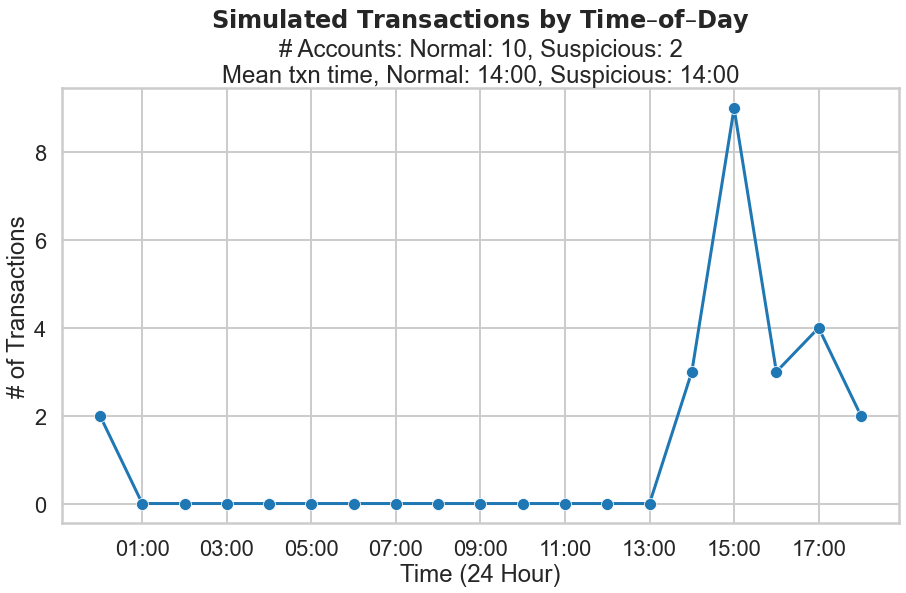

In [332]:
fig, ax = plt.subplots(figsize=(15,8))
sns.lineplot(x='send_txn_times', y='value', data=df, ax=ax,
    markers=True,  marker='o')
sns.set_style('whitegrid')
sns.set_context('poster')
ax.set(xlabel='Time (24 Hour)', ylabel='# of Transactions',
title=r"$\bf{Simulated\ Transactions\ by\ Time–of–Day}$" 
    f"\n# Accounts, Normal: {parameters['num_agents_per_type']['normal']}, "
    f"Suspicious: {parameters['num_agents_per_type']['suspicious']}\n"
    f"Mean txn time, Normal: {parameters['mean_txn_hrs']['normal']}:00,"
    f" Suspicious: {parameters['mean_txn_hrs']['normal']}:00"
    )
ax.xaxis.set_major_locator(mdates.HourLocator(interval=2))
ax.xaxis.set_minor_locator(mdates.HourLocator(interval=1))
ax.xaxis.set_major_formatter(DateFormatter("%H:%M"))